# 2 - Composition Operators 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

from helicast.column_filters import (
    AllSelector,
    DTypeRemover,
    DTypeSelector,
    NameRemover,
    NameSelector,
    RegexRemover,
    RegexSelector,
)
from helicast.pandas_sklearn import (
    PandasPipeline,
    PandasTransformedTargetRegressor,
    PandasTransformer,
    PandasSelectiveTransformer
)

from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
def read_data() -> pd.DataFrame:
    df = pd.read_csv("../data/victoria-daily-electricity.csv")
    df = df.convert_dtypes()
    df["school_day"] = df["school_day"].astype("category")
    df = df.ffill()
    return df

df = read_data()
display(df.dtypes)
df

date               string[python]
demand                    Float64
RRP                       Float64
demand_pos_RRP            Float64
RRP_positive              Float64
demand_neg_RRP            Float64
RRP_negative              Float64
frac_at_neg_RRP           Float64
min_temperature           Float64
max_temperature           Float64
solar_exposure            Float64
rainfall                  Float64
school_day               category
holiday            string[python]
dtype: object

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.03,25.633696,97319.24,26.415953,2315.79,-7.24,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.01,33.138988,121082.015,38.837661,8523.995,-47.809777,0.0625,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.54,34.564855,142300.54,34.564855,0.0,0.0,0.0,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.00556,104330.715,25.00556,0.0,0.0,0.0,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.2,26.724176,118132.2,26.724176,0.0,0.0,0.0,15.0,22.0,30.7,0.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,99585.835,-6.076028,41988.24,26.980251,57597.595,-30.173823,0.625,12.8,26.0,22.0,0.0,N,N
2102,2020-10-03,92277.025,-1.983471,44133.51,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.57,-0.163066,0.0625,13.5,29.5,8.4,0.0,N,N
2104,2020-10-05,113610.03,36.764701,106587.375,39.616015,7022.655,-6.51155,0.083333,9.1,12.7,7.3,12.8,N,N


2024-04-09 00:03:45,577 - INFO - helicast.column_filters._regex - _get_matched_columns - For pattern 'demand', matched ['demand', 'demand_pos_RRP', 'demand_neg_RRP'].
2024-04-09 00:03:45,578 - INFO - helicast.column_filters._regex - _get_matched_columns - All unique columns matching: ['demand', 'demand_neg_RRP', 'demand_pos_RRP'].
2024-04-09 00:03:45,578 - INFO - helicast.column_filters._base - __call__ - Selecting ['date', 'RRP', 'RRP_positive', 'RRP_negative', 'frac_at_neg_RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall', 'school_day', 'holiday'], dropped ['demand', 'demand_pos_RRP', 'demand_neg_RRP']
2024-04-09 00:03:45,579 - INFO - helicast.column_filters._base - __call__ - Selecting ['demand', 'RRP', 'demand_pos_RRP', 'RRP_positive', 'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall'], dropped ['date', 'school_day', 'holiday']
2024-04-09 00:03:45,579 - INFO - helicast.column_filters._base 

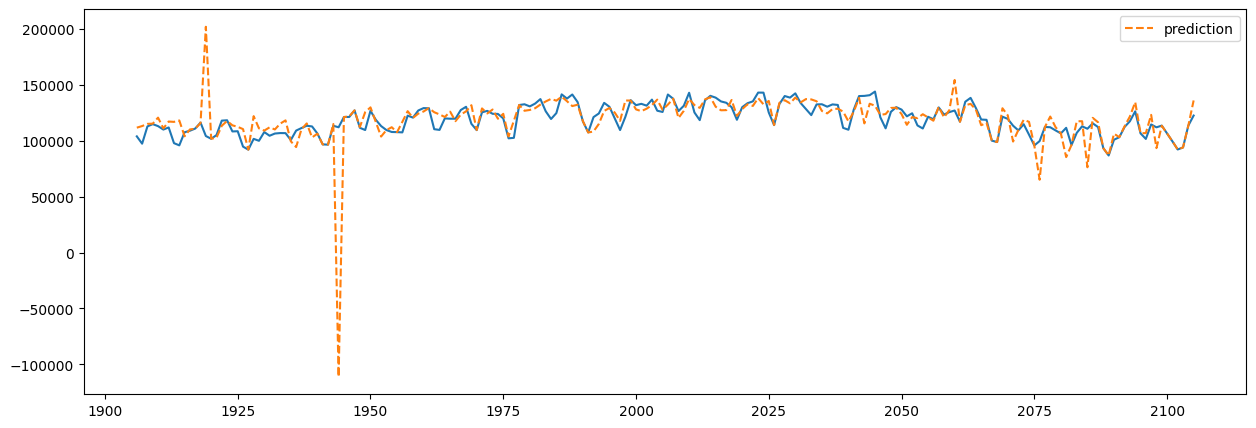

In [3]:
from sklearn.ensemble import AdaBoostRegressor

model = PandasPipeline(
    [
        ("scaler", MinMaxScaler()),
        ("reg", AdaBoostRegressor(GaussianProcessRegressor(), n_estimators=5)),
    ]
)

X = (RegexRemover(patterns="demand") & DTypeSelector(dtypes="number")).fit_transform(df)
y = NameSelector(names="demand").fit_transform(df)
model.fit(X, y)

#print(model[-1].coef_)


plt.figure(figsize=(15, 5))
plt.plot(y[-200:])
plt.plot(model.predict(X)[-200:], "--", label="prediction")
plt.legend()

2024-04-09 00:03:48,767 - INFO - helicast.column_filters._regex - _get_matched_columns - For pattern 'demand', matched ['demand', 'demand_pos_RRP', 'demand_neg_RRP'].
2024-04-09 00:03:48,769 - INFO - helicast.column_filters._regex - _get_matched_columns - All unique columns matching: ['demand', 'demand_neg_RRP', 'demand_pos_RRP'].
2024-04-09 00:03:48,769 - INFO - helicast.column_filters._base - __call__ - Selecting ['date', 'RRP', 'RRP_positive', 'RRP_negative', 'frac_at_neg_RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall', 'school_day', 'holiday'], dropped ['demand', 'demand_pos_RRP', 'demand_neg_RRP']
2024-04-09 00:03:48,771 - INFO - helicast.column_filters._base - __call__ - Selecting ['demand', 'RRP', 'demand_pos_RRP', 'RRP_positive', 'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall'], dropped ['date', 'school_day', 'holiday']
2024-04-09 00:03:48,771 - INFO - helicast.column_filters._base 

0.6677865501553149


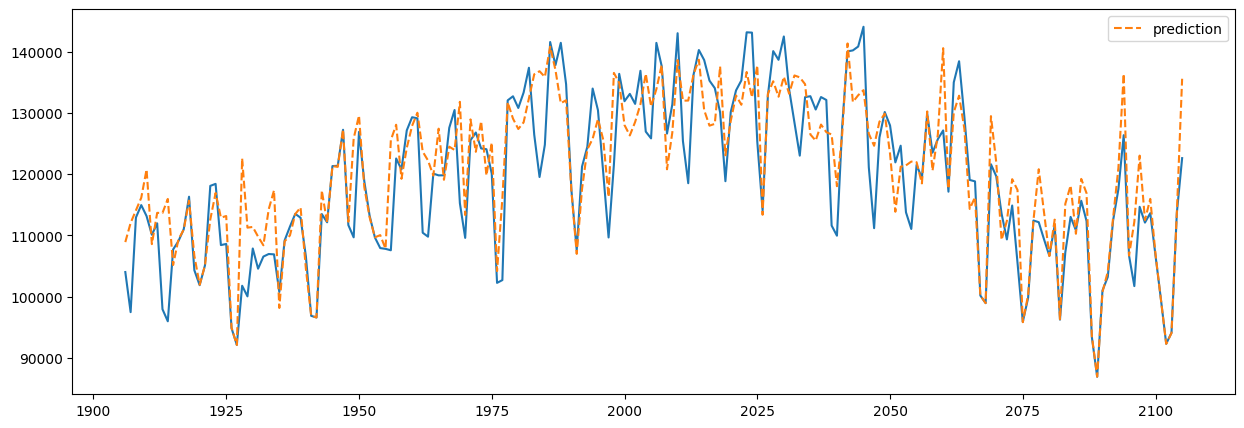

In [4]:
from sklearn.pipeline import Pipeline

model = PandasTransformedTargetRegressor(
    regressor=Pipeline(
        [
            ("scaler", MinMaxScaler()),
            ("reg", GaussianProcessRegressor()),
        ]
    ),
    transformer=MinMaxScaler(),
)


X = (RegexRemover(patterns="demand") & DTypeSelector(dtypes="number")).fit_transform(df)
y = NameSelector(names="demand").fit_transform(df)
model.fit(X, y)

print(model.score(X, y, scoring="r2"))



plt.figure(figsize=(15, 5))
plt.plot(y[-200:])
plt.plot(model.predict(X)[-200:], "--", label="prediction")
plt.legend()

In [12]:
# This will fail
try:
    display(PandasTransformer(MinMaxScaler()).fit_transform(df))
except:
    print("Fails due to wrong dtypes!!!")
    

Fails due to wrong dtypes!!!


In [13]:
PandasSelectiveTransformer(
    transformer=MinMaxScaler(),
    filter=DTypeSelector(dtypes="number")
).fit_transform(df)



2024-04-09 00:04:54,491 - INFO - helicast.column_filters._base - __call__ - Selecting ['demand', 'RRP', 'demand_pos_RRP', 'RRP_positive', 'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall'], dropped ['date', 'school_day', 'holiday']
2024-04-09 00:04:54,496 - INFO - helicast.column_filters._base - __call__ - Selecting ['demand', 'RRP', 'demand_pos_RRP', 'RRP_positive', 'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall'], dropped ['date', 'school_day', 'holiday']


,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,0.169948,0.006960,0.430037,0.002832,0.040206,0.978844,0.033333,0.463504,0.518841,0.702454,0.000000,N,Y
1,2015-01-02,0.520242,0.008608,0.614724,0.005571,0.147992,0.860295,0.100000,0.540146,0.863768,0.800613,0.000000,N,N
2,2015-01-03,0.668613,0.008921,0.779636,0.004629,0.000000,1.000000,0.000000,0.708029,0.846377,0.791411,0.000000,N,N
3,2015-01-04,0.224830,0.006823,0.484531,0.002521,0.000000,1.000000,0.000000,0.572993,0.359420,0.751534,0.076923,N,N
4,2015-01-05,0.386139,0.007200,0.591797,0.002900,0.000000,1.000000,0.000000,0.525547,0.376812,0.920245,0.000000,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,0.169373,0.000000,0.000000,0.002957,1.000000,0.911829,1.000000,0.445255,0.492754,0.653374,0.000000,N,N
2102,2020-10-03,0.083949,0.000898,0.016673,0.004160,0.835860,0.901999,0.933333,0.613139,0.591304,0.585890,0.000000,N,N
2103,2020-10-04,0.105040,0.006823,0.362123,0.002867,0.095500,0.999524,0.100000,0.470803,0.594203,0.236196,0.000000,N,N
2104,2020-10-05,0.333285,0.009404,0.502070,0.005742,0.121926,0.980973,0.133333,0.310219,0.107246,0.202454,0.234432,N,N
